##### Setup (imports, constants, etc.)

In [1]:
from copy import deepcopy
import pdb
import warnings
from imp import reload
import time
from pprint import pprint
import random
from copy import deepcopy
import pickle
import time
import multiprocessing

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (StratifiedShuffleSplit, train_test_split,
                                     validation_curve)
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import (SelectKBest, chi2, mutual_info_classif,
                                       f_classif)
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import (LabelBinarizer, LabelEncoder,
                                   MinMaxScaler, StandardScaler,
                                   OneHotEncoder, Imputer)
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from IPython.display import display
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
from xgboost import XGBClassifier
from pyglmnet import GLM
from sklearn.utils.validation import check_is_fitted
from tpot import TPOTClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

import pdir

from outlier_detection import *
from preprocessing import (LogTransformer, SqrtTransformer, BedBathImputer,
                           LatLongImputer, LenExtractor, GroupSumExtractor,
                           WordCntExtractor, DayBinarizer, ItemSelector,
                           feature_prep, impute_w_constant)
from eda_plots import *
from validation_plots import *
from main import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.4f' % x)

try:
    multiprocessing.set_start_method('forkserver')
except RuntimeError as e:
    if str(e) != 'context has already been set':
        raise e

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
SUBM_DIR = '../Submissions/'
TEST_DIR = '../Tests/'
REPORT_IMG_DIR = '../Report-Images/'
TPOT_DIR = './TPOT/'

TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
SAMPLE_FP = ''.join([DAT_DIR, 'sample_submission.csv'])
DF_TRAIN_PKL = ''.join([DAT_DIR, 'df_train.pkl'])
DF_TEST_PKL = ''.join([DAT_DIR, 'df_test.pkl'])

scorer_acc = make_scorer(accuracy_score)

# using built-in 'neg_log_loss' scoring param used for simplicity
# source code show exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                     needs_proba=True)

scoring = 'neg_log_loss'

df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Notes

__About the target variable__:
- From Kaggle: "The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site."
- This means listings taken down quickly due to a quick close will be classified with the same interest level as one that takes longer to close and has the same number of inquiries.
- If we take a more holistic approach to interest level, another distortion could arise with listings that have lots of inquiries due to listings that are higher quality relative to the actual property.
- Ultimately, the distorting factor of duration is unknown because, assuming the listing were shown as they are now, the search ranking is determined not only by "freshness" but also by the quality of the posting and the property itself (possibly derived from interest level). 

__Dealing with class imbalance__:
- High: 0.078, medium: 0.228, low: 0.695
- https://stats.stackexchange.com/questions/122409/why-downsample
- For probabilistic models, we need that informatation of the imbalance!
- If balance, logloss worse than benchmark

__Logistic Regression__
- Cost function favors majority class, but so does the class distribution!
- ~~`Sklearn` implementation has `weight` parameter with `balanced` option.~~

__Dealing with outliers__:
- Examine with HDBSCAN
- Look at classes of outliers

__Logistic Regression__:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- `Liblinear` only compatible with `ovr`, use others for `multinomial`
- For build-in CV for regularization strength, use: [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

__Gradient boosted trees__:
- 

Stochastic Gradient Descent with modified huber loss:
- using sklearn's [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- `modified_huber` is another smooth loss that brings tolerance to outliers as well as probability estimates

__Train test split__

- 

# Learning

## Benchmark

In [2]:
df = read_rental_interest(DF_TRAIN_PKL)
y = LabelBinarizer().fit_transform(df.interest_level)

avg_probs = (np.sum(y, axis=0)/len(y)).tolist()
baseline_pred = np.array(avg_probs*len(y)).reshape(-1, 3)
baseline_score = log_loss(y, baseline_pred)
baseline_score

0.78857691143225461

## Spot-Check

Basic features:
- Price (logged), Bedrooms, Bathrooms, Latitude, Longitude
- Binarized day created (Monday, Tuesday, etc.)
- Number of photos, features and description word count
- Indicator variables for zero values of counts above (ignored by XGBoost)

### Uniform Setup for Spot-Checks

In [3]:
features = [
    'price_lg', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
    'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq',  # count aggregates
    'day_mon', 'day_tue', 'day_wed', 'day_thu',    # day dummies
    'day_fri', 'day_sat', 'day_sun',
]

df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_prepped = feature_prep(X).loc[:, features]

X_train, X_test, y_train, y_test = train_test_split(
    X_prepped, y, random_state=SEED, stratify=y
)

# default 3 fold for GridSearchCV
spot_cv = 3

### Logistic Regression

In [4]:
cv = 3

lr_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                            n_jobs=1, random_state=SEED)

pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('lr_clf', lr_clf)
])

params = dict(
    lr_clf__C=np.logspace(-4, 4, 9),
)
grid = GridSearchCV(pipe, params, n_jobs=-1, scoring=scoring, cv=cv)

%timeit -r1 -n1 grid.fit(X_train, y_train)

print(best_grid_score(grid))

3.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best score: -0.7000 ± 0.0015 (mean ± std. dev.)

*** For parameters: ***
lr_clf__C=10.0


Train score:    -0.6983
Test score :    -0.6989



Process ForkPoolWorker-25:
Process ForkPoolWorker-29:
Process ForkPoolWorker-30:
Process ForkPoolWorker-31:
Process ForkPoolWorker-26:
Process ForkPoolWorker-27:
Process ForkPoolWorker-24:
Process ForkPoolWorker-28:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/multiprocessing/proc

KeyboardInterrupt: 

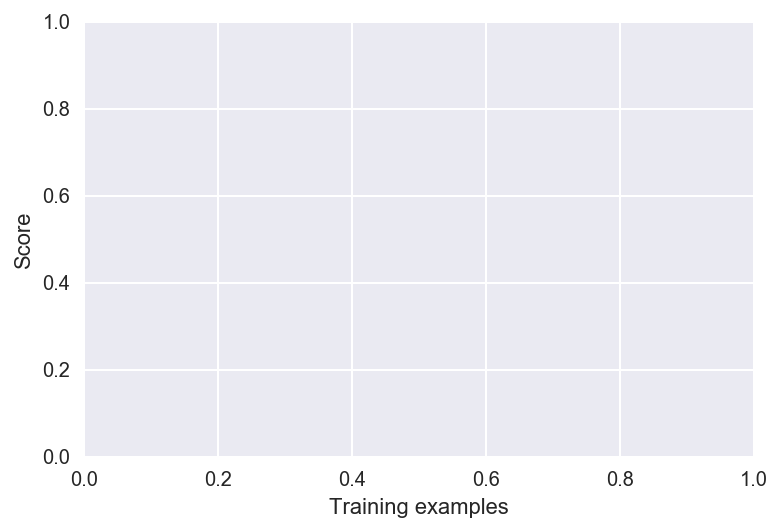

In [5]:
cv = 3

clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.4f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.4f}'.format(-log_loss(y_test, y_pred)))
print()

# kwargs so %timeit works with multiline arguments
kwargs = dict(estimator=clf, X=X_train, y=y_train,
              clf_name='LogisticRegression',
              cv=cv, scoring=scoring, n_jobs=-1)

%timeit -r1 -n1 plot_learning_curve(**kwargs)
# plt.savefig(''.join([REPORT_IMG_DIR, 'stg1a-lr-learning-curve.png']),
#             dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ge = GridSearchExplorer(grid)

ge.plot(x='lr_clf__C', metric='mean_test_score', kind='point', ax=ax)
fig.set_figwidth(8)
plt.xticks(rotation=25)
plt.show()

### XGBoost

In [7]:
# GridSearchCV takes about 5 min with 8 cores
# Might not want to run it again
RUN_XGB = True

if RUN_XGB:
    cv = 3
    
    xgb_clf = XGBClassifier(objective='multi:softprob', subsample=0.8, 
                            colsample_bytree=0.8, nthread=1, seed=SEED)

    params = dict(
        max_depth=[4, 5, 6, 7],
        learning_rate=[0.1, 1.5],
        n_estimators=[100, 150, 200],
    )
    grid = GridSearchCV(xgb_clf, params, n_jobs=-1,
                        scoring=scoring, cv=cv)

    %timeit -r1 -n1 grid.fit(X_train, y_train)

    print(best_grid_score(grid))

4min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best score: -0.6157 ± 0.0040 (mean ± std. dev.)

*** For parameters: ***
learning_rate=0.1
max_depth=6
n_estimators=200


Train score:    -0.5000
Test score :    -0.6087

41.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


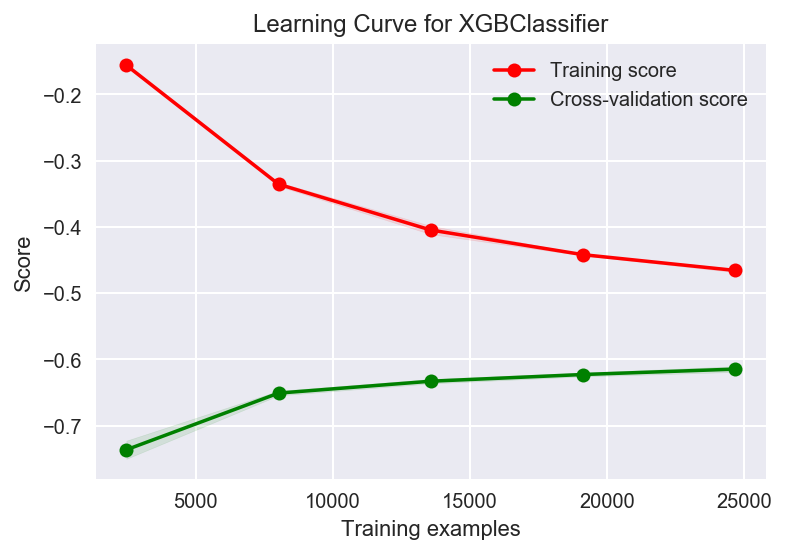

In [8]:
if RUN_XGB:
    cv = 3
    
    clf = grid.best_estimator_

    y_pred = clf.predict_proba(X_train)
    print('Train score: {:>10.4f}'.format(-log_loss(y_train, y_pred)))

    y_pred = clf.predict_proba(X_test)
    print('Test score : {:>10.4f}'.format(-log_loss(y_test, y_pred)))
    print()

    # kwargs so %timeit works with multiline arguments
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  clf_name='XGBClassifier',
                  cv=cv, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)
#     plt.savefig(''.join([REPORT_IMG_DIR, 'stg1b-xgb-learning-curve.png']),
#                 dpi=300, bbox_inches='tight')

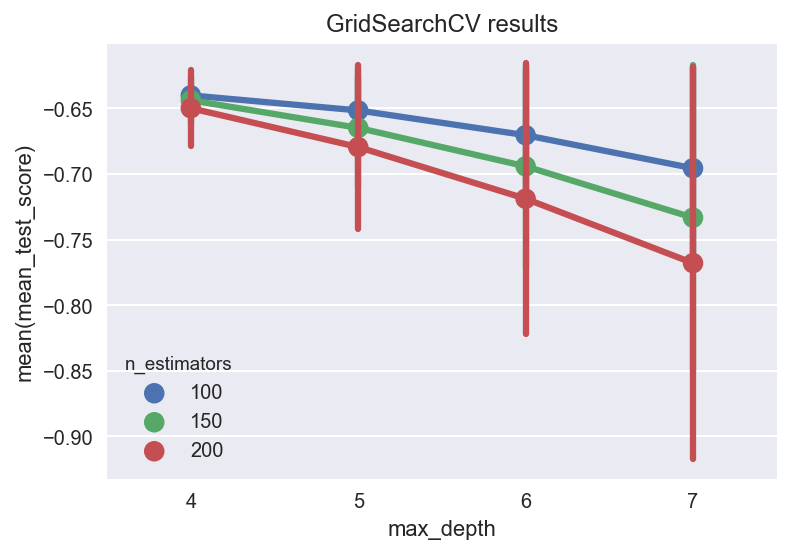

In [9]:
if RUN_XGB:
    fig, ax = plt.subplots()

    ge = GridSearchExplorer(grid)

    ge.plot(x='max_depth', hue='n_estimators',
             metric='mean_test_score', kind='point', ax=ax)

### TPOT

In [72]:
if 1 == 0:

    tpot_light = TPOTClassifier(
        generations=5, population_size=20, verbosity=2,
        scoring='neg_log_loss', random_state=SEED, n_jobs=1,
        config_dict=''.join([TPOT_DIR, 'classifier_light.py'])
    )
    tpot_light.fit(X_train, y_train)
    print(tpot_light.score(X_test, y_test))
    tpot_light.export(''.join([TPOT_DIR, 'tpot_bench_light.py']))
    pickle.dump(tpot_light, ''.join([TPOT_DIR, 'tpot_bench_light.pkl']))

Optimization Progress:  30%|███       | 36/120 [02:06<04:19,  3.09s/pipeline]

Generation 1 - Current best internal CV score: 0.6930710722925333


Optimization Progress:  47%|████▋     | 56/120 [13:58<37:13, 34.90s/pipeline]  

Generation 2 - Current best internal CV score: 0.692311442516971


Optimization Progress:  64%|██████▍   | 77/120 [23:49<13:48, 19.27s/pipeline]

Generation 3 - Current best internal CV score: 0.692311442516971


Optimization Progress:  78%|███████▊  | 94/120 [23:58<03:03,  7.07s/pipeline]

Generation 4 - Current best internal CV score: 0.692311442516971


Generation 5 - Current best internal CV score: 0.6708706420692458

Best pipeline: LogisticRegression(DecisionTreeClassifier(StandardScaler(input_matrix), DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=10, DecisionTreeClassifier__min_samples_leaf=19, DecisionTreeClassifier__min_samples_split=17), LogisticRegression__C=25.0, LogisticRegression__dual=DEFAULT, LogisticRegression__penalty=DEFAULT)
0.664350031019


In [73]:
if 1 == 0:
    tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
                          scoring=scoring, random_state=SEED, n_jobs=1,
    )
    %timeit -r1 -n1 tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export(''.join([TPOT_DIR, 'tpot_bench.py']))
    pickle.dump(tpot, ''.join([TPOT_DIR, 'tpot_bench.pkl']))

Optimization Progress:  32%|███▎      | 39/120 [24:07<34:36, 25.64s/pipeline]  

Generation 1 - Current best internal CV score: 0.6364872651543181


Optimization Progress:  48%|████▊     | 58/120 [31:57<32:36, 31.56s/pipeline]

Generation 2 - Current best internal CV score: 0.6311048496807092


Optimization Progress:  64%|██████▍   | 77/120 [34:21<08:49, 12.32s/pipeline]

Generation 3 - Current best internal CV score: 0.6291235790157857


Optimization Progress:  81%|████████  | 97/120 [40:58<07:09, 18.68s/pipeline]

Generation 4 - Current best internal CV score: 0.6185133810756033


Generation 5 - Current best internal CV score: 0.6185133810756033

Best pipeline: XGBClassifier(input_matrix, XGBClassifier__learning_rate=DEFAULT, XGBClassifier__max_depth=6, XGBClassifier__min_child_weight=4, XGBClassifier__n_estimators=100, XGBClassifier__nthread=1, XGBClassifier__subsample=0.45)
51min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
0.617577228493


Train score:   -0.56227
Test score :   -0.61758




TPOT closed prematurely. Will use the current best pipeline.


RuntimeError: A pipeline has not yet been optimized. Please call fit() first.

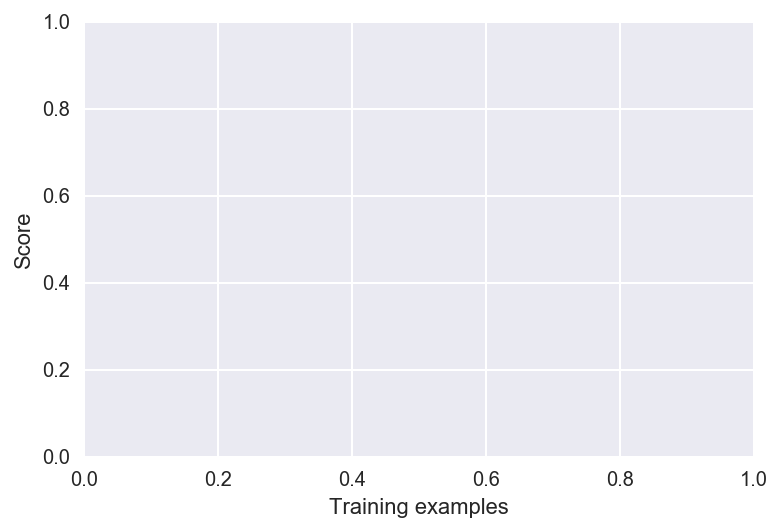

In [75]:
if 1 == 10000:
    clf = tpot

    y_pred = clf.predict_proba(X_train)
    print('Train score: {:>10.4f}'.format(-log_loss(y_train, y_pred)))

    y_pred = clf.predict_proba(X_test)
    print('Test score : {:>10.4f}'.format(-log_loss(y_test, y_pred)))
    print()

    # kwargs so %timeit works with multiline arguments
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  cv=5, scoring=scoring, n_jobs=1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)

## Model Refinement
- Refine XGBoost, best performing model in spot-check

### Parameter Notes

- For imbalanced classes
    - `scale_pos_weigh`, [default=1] (faster, no effect on score)
        - See speed improvement section for details
    - `max_delta_step`, [default=0]
        - From overfitting guide: If you care about predicting the right probability
In such a case, you cannot re-balance the dataset
In such a case, set parameter `max_delta_step` to a finite number (say 1) will help convergence
        - From docs: Maximum delta step we allow each tree's weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update

### Uniform Setup for Refinements

In [3]:
features = [
    'price_lg', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
    'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq',  # count aggregates
    'day_mon', 'day_tue', 'day_wed', 'day_thu',    # day dummies
    'day_fri', 'day_sat', 'day_sun',
]

df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level


X_prepped = feature_prep(X, imp_constant=-999).loc[:, features]

X_train, X_test, y_train, y_test = train_test_split(
    X_prepped, y, random_state=SEED, stratify=y
)

# labels are reduced by one to match num_label format in xgb'
label_train = y_train-1
label_test  = y_test-1

dtrain = xgb.DMatrix(X_train, label_train, missing=-999,
                     feature_names=features)
dtest  = xgb.DMatrix(X_test, label_test, missing=-999,
                     feature_names=features)

In [29]:
# extractor = FeatureUnion([
#     ('pre_processed', ItemSelector(
#         ['price_lg', 'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq'])),
#     ('coordinates', make_pipeline(
#         ItemSelector(['latitude', 'longitude']),
#         LatLongImputer(how='mean', broad=False),
#     )),
#     ('rooms', make_pipeline(
#         ItemSelector(['bathrooms', 'bedrooms']),
#         BedBathImputer(how='medians'))),   
#     ('day_dummies', ItemSelector([
#         'day_mon', 'day_tue', 'day_wed', 'day_thu',
#         'day_fri', 'day_sat', 'day_sun' 
#     ])),
# ])

### Stage 2: XGBoost's missing value handling
- Stage 0: Benchmark
- Stage 1: Spot-Check

Runtime: 1min 17s

-0.6107


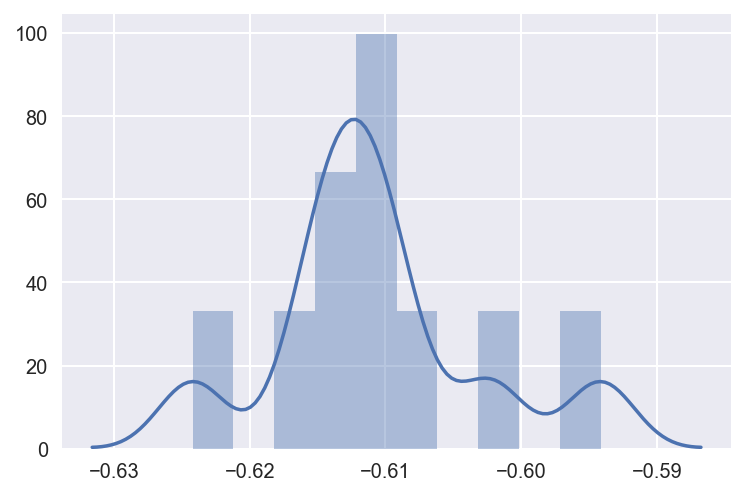

In [11]:
RUN_XGB = True

if RUN_XGB:
    cv = 10  # higher number gets more detailed hist plot

    # Hyperparameters that performed the best in spot-check grid search
    params = dict(
        objective='multi:softprob', max_depth=6,
        learning_rate=0.1, n_estimators=200,
        subsample=0.8, colsample_bytree=0.8,
        missing=-999, nthread=1, seed=SEED,
    )
    xgb_clf = XGBClassifier(**params)
    
    fit_params = dict(
        eval_metric='mlogloss',
    )
    
    start = time.time()
    scores = cross_val_score(
        estimator=xgb_clf, X=X_train, y=y_train,
        cv=cv, scoring=scoring, n_jobs=-1,
        fit_params=fit_params,
    )
    end = time.time()
    print('Runtime: {}min {}s\n'.format(*to_min_secs(end-start)))
    
    print(round(np.mean(scores), 4))

    sns.distplot(scores, bins=cv)
    plt.show()

1min 42s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


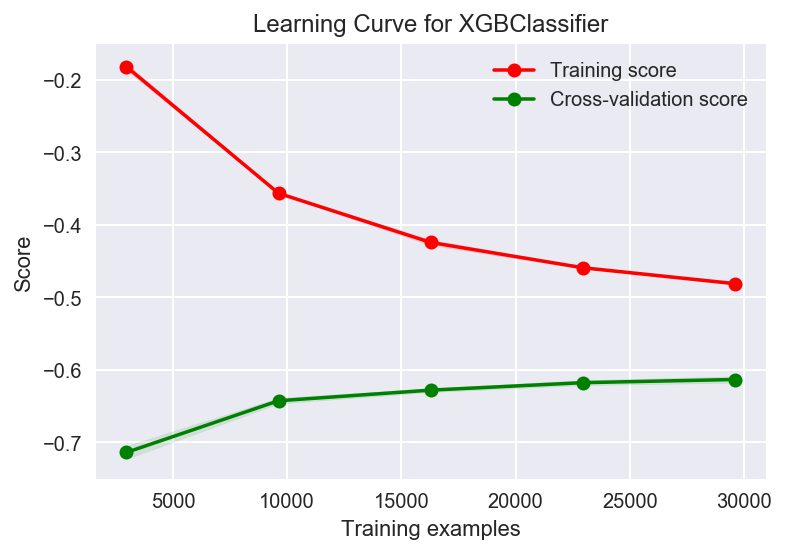

In [12]:
if RUN_XGB:
    
    # so %timeit works with multiline arguments
    kwargs = dict(estimator=xgb_clf, X=X_train, y=y_train,
                  cv=5, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)
#     plt.savefig(''.join([REPORT_IMG_DIR, 'stg2-learning-curve.png']),
#                 dpi=300, bbox_inches='tight')

### Stage 3: Hyperparameter Tuning

Method adapted from: Complete Guide to Parameter Tuning in XGBoost [blog post](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) on Analytics Vidhya

- Native XGBoost multithreading does not work within ipython notebook, without messy `%writefile`/`%run` hack. 
    - This is fine given that `xgb.cv` is barely used instead of `GridSearchCV`
    - Info from xgboost [github script](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_parallel.py):
```python
# NOTE: on posix systems, this *has* to be here and in the
# `__name__ == "__main__"` clause to run XGBoost in parallel processes
# using fork, if XGBoost was built with OpenMP support. Otherwise, if you
# build XGBoost without OpenMP support, you can use fork, which is the
# default backend for joblib, and omit this.
```

#### Speed improvements

From [documentation](http://xgboost.readthedocs.io/en/latest/parameter.html):
- `scale_pos_weight`, [default=1]
  - NOTE: Only applicable when labels are weights (not done in this case)
  - No effect on score (at least in this case, tested below)
  - If you care only about the ranking order (AUC) of your prediction
Balance the positive and negative weights, via scale_pos_weight
  - Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative  cases) / sum(positive cases) See [Parameters Tuning](https://github.com/dmlc/xgboost/blob/master/doc/how_to/param_tuning.md) for more discussion. Also see Higgs Kaggle competition demo for examples: [R](../demo/kaggle-higgs/higgs-train.R ), [py1](https://github.com/dmlc/xgboost/blob/master/demo/kaggle-higgs/higgs-numpy.py), [py2](https://github.com/dmlc/xgboost/blob/master/demo/kaggle-higgs/higgs-cv.py), [py3](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py)

In [11]:
RUN_XGB = True

if RUN_XGB:
    cv = 5

    # Hyperparameters that performed the best in spot-check grid search
    xgb_clf = XGBClassifier(objective='multi:softprob', subsample=0.8,
                            colsample_bytree=0.8, max_depth=6,
                            learning_rate=0.1, n_estimators=200,
                            missing=-999, scale_pos_weight=1,
                            nthread=1, seed=SEED)

    params = dict(
        scale_pos_weight=[1]+list(range(18, 25)),
    )
    grid = GridSearchCV(xgb_clf, params, n_jobs=-1,
                        scoring=scoring, cv=cv)

    %%timeit -r1 -n1 grid.fit(feature_prep(X_train, imp_constant=-999),
                              y_train)

4min 51s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


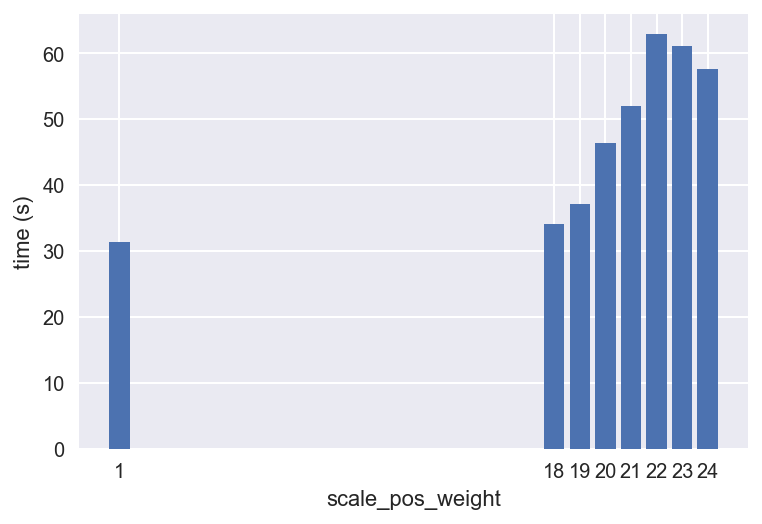

In [12]:
if RUN_XGB:

    height = grid.cv_results_['mean_fit_time']
    left = np.array(parameters['scale_pos_weight'])
    plt.bar(left, height)

    plt.xticks(left)
    plt.xlabel('scale_pos_weight')
    plt.ylabel('time (s)')
    plt.show()

#### Check `sklearn`-style API results against `xbg.cv()` API

In [115]:
RUN_XGB = True

if RUN_XGB:

    cv_folds = 5
    num_boost_round = 200  # n_estimators equivalent
    
    # Hyperparameters that performed the best in spot-check grid search
    # Note that nthread only works if run top-level under '__main__'
    params = dict(
        objective='multi:softprob',
        max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        missing=-999, nthread=-1, seed=SEED,
        num_class=3, eval_metric='mlogloss',
    )

    start = time.time()

    eval_hist = xgb.cv(
        params, dtrain, nfold=cv_folds, seed=SEED,
        stratified=True,
        num_boost_round=num_boost_round,
    )

    end = time.time()
    print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
    print()
    print(best_xgb_cv_score(eval_hist))

Runtime: 1min 26s

Best CV score (round 199):  0.6154 ± 0.0026 (mean ± std. dev.)
Train score (round 199):    0.4814 ± 0.0016 (mean ± std. dev.)



Output:
```
Runtime: 1min 26s

Best CV score (round 199):  0.6154 ± 0.0026 (mean ± std. dev.)
Train score (round 199):    0.4814 ± 0.0016 (mean ± std. dev.)
```

Conclusion:
- Score within 95% confidence interval earlier GridSearchCV best score
- Therefore results match

#### Step 1a: _Fix_ `learning_rate` and `n_estimators` for tuning tree-based parameters
- First effort with _fixed_ `learning_rate` and `n_estimators` in `xgb.cv`

In [368]:
RUN_XGB = True

if RUN_XGB:
    
    cv_folds = 4
    num_boost_round = 1000
    early_stopping_rounds = 50

    # Hyperparameters that performed the best in spot-check grid search
    # Note that nthread with only works if run top-level under '__main__'
    params = dict(
        objective='multi:softprob',
        max_depth=10, learning_rate=0.1,
        gamma=6, subsample=1,  # learning curve
        colsample_bytree=0.5,
        missing=-999, nthread=-1, seed=SEED,
        num_class=3, eval_metric='mlogloss',        
    )

    start = time.time()

    eval_hist = xgb.cv(
        params, dtrain, nfold=cv_folds, seed=SEED,
        stratified=True,
        num_boost_round=num_boost_round,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=25,
    )

    end = time.time()
    print()
    print(best_xgb_cv_score(eval_hist))
    print('Runtime: {}min {}s\n'.format(*to_min_secs(end-start)))

[0]	train-mlogloss:1.06191+0.000139204	test-mlogloss:1.06244+3.50954e-05
[25]	train-mlogloss:0.714216+0.00546434	test-mlogloss:0.725273+0.00518844
[50]	train-mlogloss:0.654064+0.00341175	test-mlogloss:0.672782+0.00349758
[75]	train-mlogloss:0.631784+0.00417855	test-mlogloss:0.655857+0.00343281
[100]	train-mlogloss:0.617702+0.00466438	test-mlogloss:0.646035+0.00330635
[125]	train-mlogloss:0.607652+0.00407791	test-mlogloss:0.639298+0.00258838
[150]	train-mlogloss:0.601009+0.00383117	test-mlogloss:0.635156+0.00221204
[175]	train-mlogloss:0.596861+0.00312301	test-mlogloss:0.632701+0.00184561
[200]	train-mlogloss:0.593683+0.00286441	test-mlogloss:0.630856+0.00170617
[225]	train-mlogloss:0.590783+0.00247097	test-mlogloss:0.629255+0.00132837
[250]	train-mlogloss:0.588707+0.00218716	test-mlogloss:0.628062+0.00134384
[275]	train-mlogloss:0.587176+0.00200217	test-mlogloss:0.627219+0.00136078
[300]	train-mlogloss:0.585393+0.00146985	test-mlogloss:0.626405+0.00137272
[325]	train-mlogloss:0.584364+

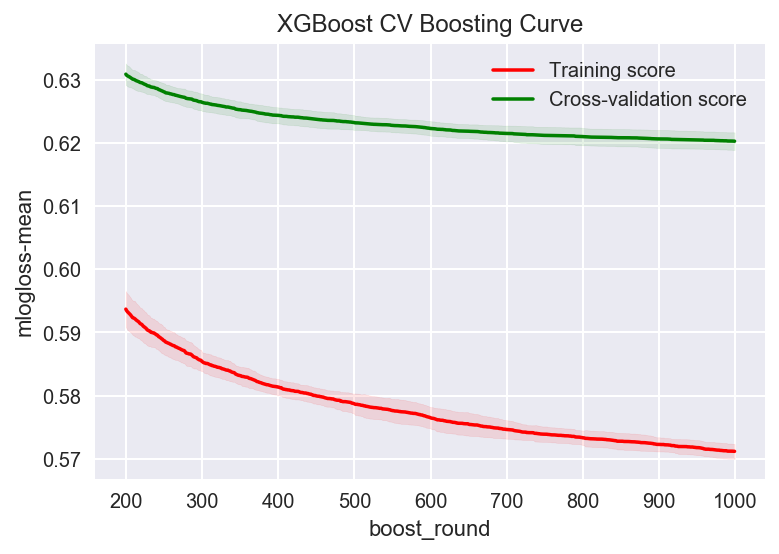

In [371]:
plot_xgb_boosting_curve(eval_hist.iloc[200:])

In [ ]:
if RUN_XGB:
    cv =4 
    
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        learning_rate=0.1, n_estimators=500,
        max_depth=10, gamma=6,
        colsample_bytree=0.5,
        missing=-999, nthread=1, seed=SEED,
    )
    
    # so %timeit works with multiline arguments
    kwargs = dict(estimator=xgb_clf, X=X_train, y=y_train,
                  cv=cv, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)
#     plt.savefig(''.join([REPORT_IMG_DIR, 'stg2-learning-curve.png']),
#                 dpi=300, bbox_inches='tight')

#### Step 1b: _Tune_ `learning_rate`, `n_estimators` and `max_depth`
- Second effort after all subsequent tuning failed after first effort.
-Using grid search with different with _fixed_ `learning_rate` and `n_estimators` in `xgb.cv`

In [355]:
RUN_XGB = False

if RUN_XGB:
    cv = 3

    xgb_clf = XGBClassifier(
        objective='multi:softprob',
#         learning_rate=0.1, n_estimators=120,  # searched here
        
        # subsample val: because model brutally overfitting
        subsample=1,
        # colsample_bytree val: because not enough feats (esp. with days)
        # 6 features 
        colsample_bytree=1,
        colsample_bylevel=.4,
        missing=-999, nthread=1, seed=SEED,
        # See step 2 learning curve, brings curves much closer
        max_depth=4, min_child_weight=1,
    )

    params = dict(  # more for max_depth=3 (much better)
        n_estimators=np.arange(100, 325, 25),
        learning_rate=np.arange(.1, .45, .05),
        max_depth=[3, 4]
    )
    grid_1b = GridSearchCV(xgb_clf, params, n_jobs=-1,
                           scoring=scoring, cv=cv)

    %timeit -r1 -n1 grid_1b.fit(X_train, y_train)

    print(best_grid_score(grid_1b))

23min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid CV score: -0.6159 ± 0.0034 (mean ± std. dev.)
Train score:        -0.5170 ± 0.0026 (mean ± std. dev.)

*** For parameters: ***
learning_rate=0.15000000000000002
max_depth=4
n_estimators=275


Output:
```
13min 56s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid CV score: -0.6176 ± 0.0031 (mean ± std. dev.)
Train score:        -0.5279 ± 0.0030 (mean ± std. dev.)

*** For parameters: ***
learning_rate=0.15000000000000002
max_depth=4
n_estimators=300
```

Plots below:
- Help understand if really close CV scores have large differences in training scores, can then choose slightly different CV with much better training

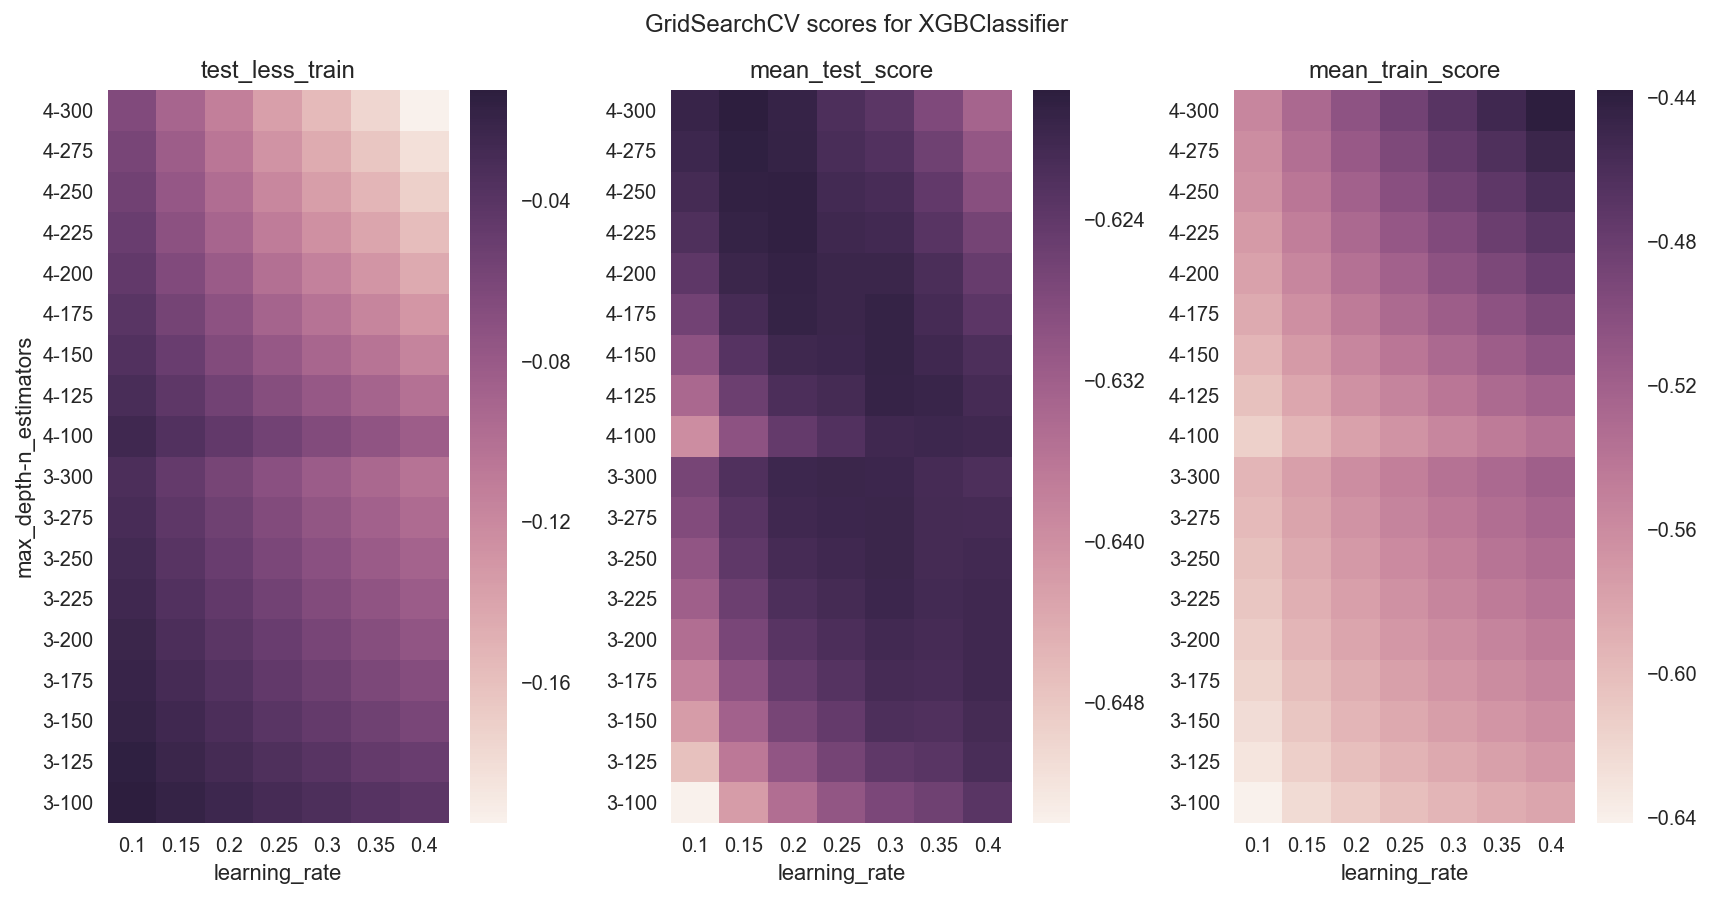

In [367]:
grid_1b = joblib.load('grid_1b_joblib.pkl')
plot_grid_heatmaps(grid_1b, x='learning_rate', figsize=(12, 6))
plt.tight_layout()

__Best balanced with depth 3:__

In [259]:
cv_results = pd.DataFrame(grid_1b.cv_results_)

params = dict(
    max_depth=3,
    n_estimators=300,
    learning_rate=0.15,
)
display(filter_grid_results(cv_results, params).iloc[:, 2:4])

,mean_test_score,mean_train_score
26,-0.6220,-0.5759


__Best balanced with depth 4:__

In [349]:
params = dict(
    max_depth=4,
    n_estimators=175,
    learning_rate=0.3,
)
display(filter_grid_results(cv_results, params).iloc[:, 2:4])

,mean_test_score,mean_train_score
84,-0.6187,-0.5164


Runtime: 0min 14s



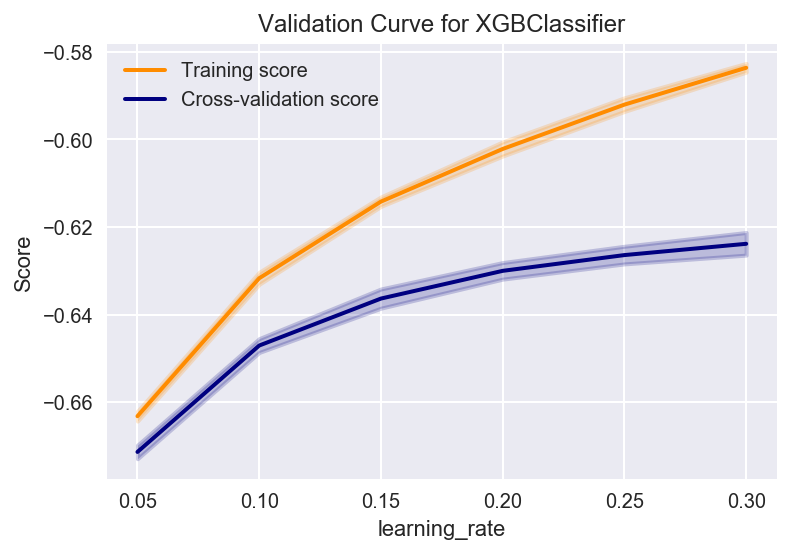

In [53]:
if RUN_XGB:
    cv = 3
    
    xgb_clf.set_params(n_estimators=125, max_depth=3)
    
    start = time.time()
    plot_validation_curve(
        xgb_clf, X_train, y_train,
        param_name='learning_rate',
        param_range=np.arange(.05, .35, .05),
        cv=cv, scoring=scoring, n_jobs=-1,
    )
    end = time.time()
    print('Runtime: {}min {}s\n'.format(*to_min_secs(end-start)))
    plt.show()

#### Step 2b: Tune `min_child_weight` and `gamma`

- "We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges."
- `min_child_weight`, [default=1]
    - One of first ways to control model complexity (with `max_depth` and `gamma`)
    - Lower values _can_ lower bias when classes are imbalanced
    - "minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression mode, this simply corresponds to minimum number of instances needed to be in each node. The larger, the more conservative the algorithm will be."

- gamma [default=0, alias: min_split_loss]
    - One of first ways to control model complexity (with `min_child_weight` and `max_depth`)
    - minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
    - range: [0,∞]

In [350]:
RUN_XGB = True

if RUN_XGB:
    cv = 3

    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        colsample_bylevel=.4,
        missing=-999, nthread=1, seed=SEED,
        
#         # best with depth 3
#         max_depth=3,
#         n_estimators=300,
#         learning_rate=0.15,
        
        # best with depth 4
        max_depth=4,
        n_estimators=175,
        learning_rate=0.3,
    )
    params = dict(
#         min_child_weight=[.2, .5, 1, 1.5, 2, 3, 4, 6],
        min_child_weight=[.2, .5, 1, 1.5, 2, 3, 4, 6],  # narrowed
#         gamma=np.arange(0, 1.2, .2),
        gamma=np.arange(0, 1.2, .2),  # narrowed
    )
    grid_2b = GridSearchCV(xgb_clf, params, n_jobs=-1,
                           scoring=scoring, cv=cv)

    %timeit -r1 -n1 grid_2b.fit(X_train, y_train)

    print(best_grid_score(grid_2b))

4min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid CV score: -0.6182 ± 0.0029 (mean ± std. dev.)
Train score:        -0.5273 ± 0.0030 (mean ± std. dev.)

*** For parameters: ***
gamma=0.8
min_child_weight=6


Output: best with depth 3

```
6min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid CV score: -0.6212 ± 0.0027 (mean ± std. dev.)
Train score:        -0.5757 ± 0.0015 (mean ± std. dev.)

*** For parameters: ***
gamma=0.4
min_child_weight=0.5
```

Output: best with depth 4

```
4min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid CV score: -0.6182 ± 0.0029 (mean ± std. dev.)
Train score:        -0.5273 ± 0.0030 (mean ± std. dev.)

*** For parameters: ***
gamma=0.8
min_child_weight=6
```

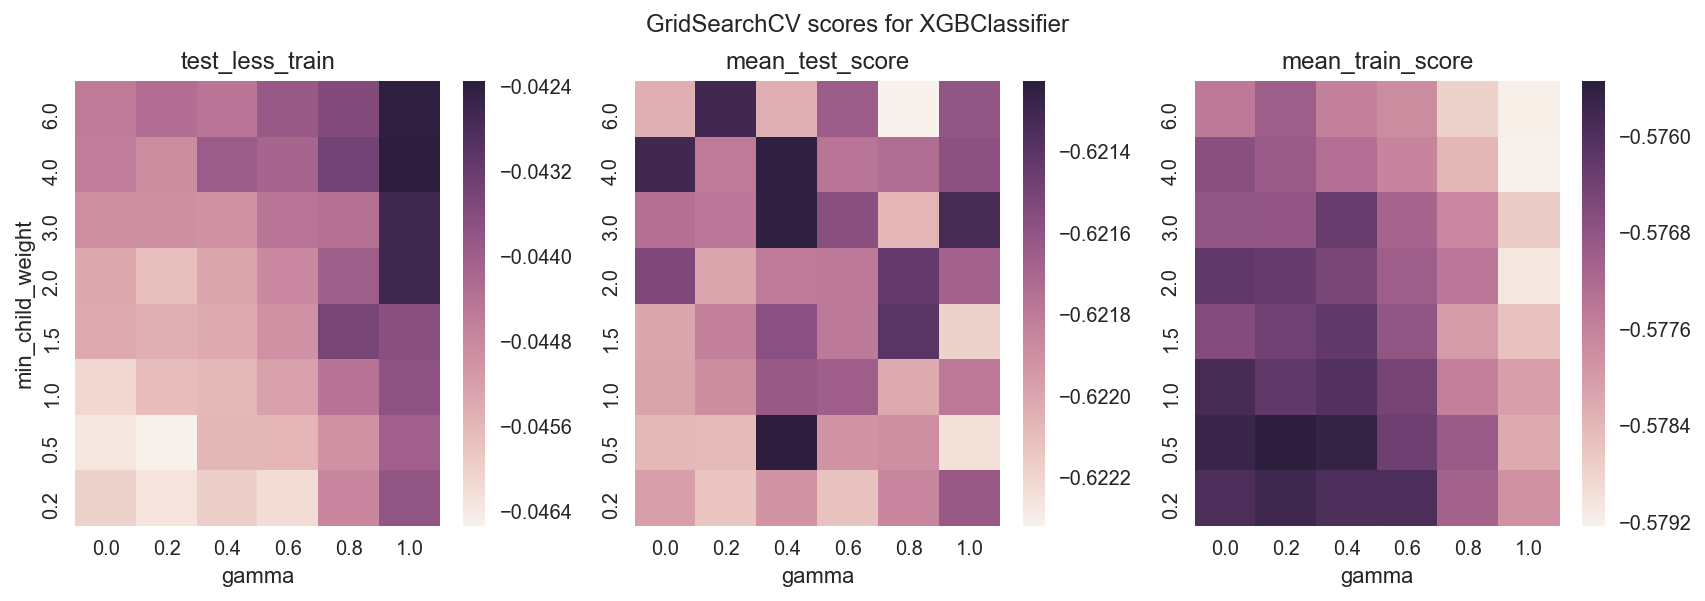

In [343]:
if RUN_XGB:
    fig = plot_grid_heatmaps(grid_2b, x='gamma')
    plt.tight_layout()

__Conclusion for depth 3:__
- Not much to gain right now, always regularized heavily by `max_depth`
- Because tree are not very deep (3 levels), `gamma` needs to be high if it can even make a difference

__Conclusion for depth 4:__
- sfdfsfdNot much to gain right now, always regularized heavily by `max_depth`
- Because tree are not very deep (3 levels), `gamma` needs to be high if it can even make a difference

__First Try with `max_depth` and `min_child_weight`:__

In [111]:
RUN_XGB = False

if RUN_XGB:
    cv = 3

    xgb_clf = XGBClassifier(
        objective='multi:softprob', max_depth=6,
        learning_rate=0.1, n_estimators=120,
        subsample=0.8, colsample_bytree=0.8,
        missing=-999, nthread=1, seed=SEED,
    )
    
    params = dict(
#         max_depth=[4, 6, 8, 10],
#         max_depth=[5, 6, 7, 8],  # narrowed
        max_depth=[3, 4, 5],
#         min_child_weight=[.2, .5, 1, 1.5, 2, 3, 4, 6],
        min_child_weight=[0.5, 1, 2],  # narrowed
    )
    grid_2a = GridSearchCV(
        xgb_clf, params, n_jobs=-1,
        scoring=scoring, cv=cv
    )

    %timeit -r1 -n1 grid_2a.fit(X_train, y_train)
    print()
    print(best_grid_score(grid_2a))

56.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best grid CV score: -0.6222 ± 0.0027 (mean ± std. dev.)
Train score:        -0.5637 ± 0.0016 (mean ± std. dev.)

*** For parameters: ***
max_depth=5
min_child_weight=2


Output:

```
56.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best grid CV score: -0.6222 ± 0.0027 (mean ± std. dev.)
Train score:        -0.5637 ± 0.0016 (mean ± std. dev.)

*** For parameters: ***
max_depth=5
min_child_weight=2
```

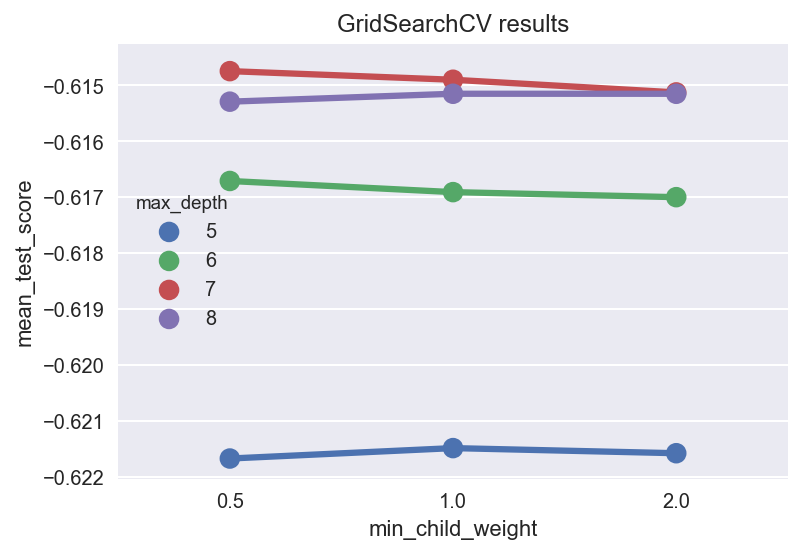

In [155]:
if RUN_XGB:

    ge = GridSearchExplorer(grid_2a)
    ge.plot('min_child_weight', 'max_depth', kind='point')
    plt.show()

59.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


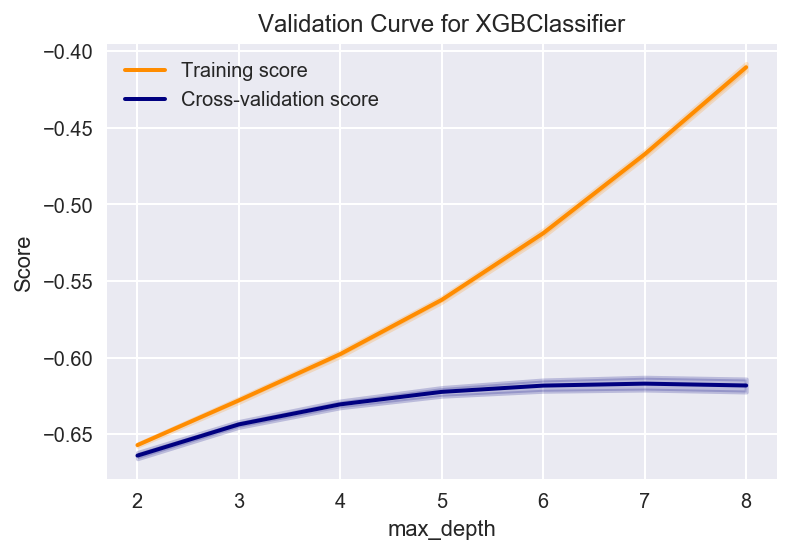

In [149]:
if RUN_XGB:
    cv = 3
    
    # so %timeit works with multiline arguments
    kwargs = dict(
        estimator=xgb_clf, X=X_train, y=y_train,
        param_name='max_depth', param_range=range(2, 9),
        cv=cv, scoring=scoring, n_jobs=-1,
    )
    %timeit -r1 -n1 plot_validation_curve(**kwargs)
    plt.show()

47.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


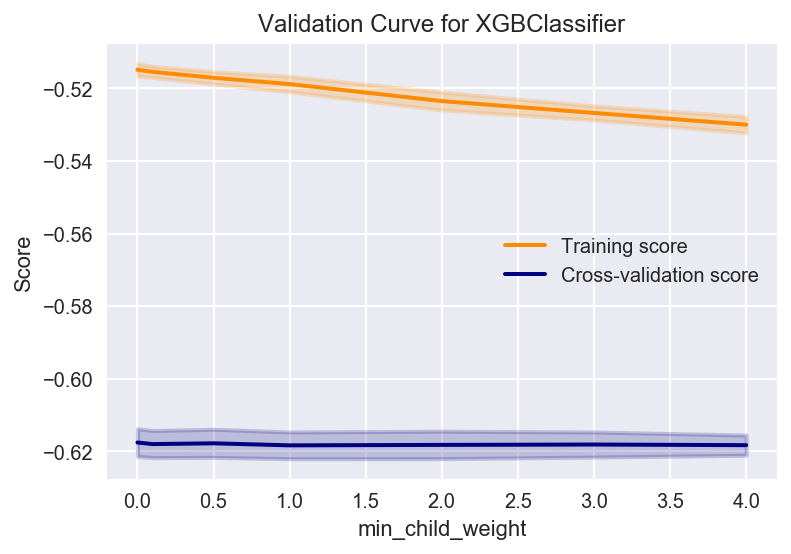

In [156]:
# so %timeit works with multiline arguments
kwargs = dict(
    estimator=xgb_clf, X=X_train, y=y_train,
    param_name='min_child_weight', param_range=[0, .1, .5, 1, 2, 3, 4],
    cv=3, scoring=scoring, n_jobs=-1,
)
%timeit -r1 -n1 plot_validation_curve(**kwargs)

Conclusion:
- Keep `min_child_weight` at default 1 and `max_depth` at 6
- not significant difference,
- can tune again later

__First try with `gamma` (a.k.a. `min_split_loss`):__
- Previously step 3 before sample params

- gamma [default=0, alias: min_split_loss]
    - minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
    - range: [0,∞]

In [98]:
RUN_XGB = True

if RUN_XGB:
    cv = 5

    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        learning_rate=0.1, n_estimators=120,
        subsample=0.8, colsample_bytree=0.8,
        missing=-999, nthread=1, seed=SEED,
        max_depth=6, min_child_weight=1,
    )

    params = dict(
        gamma=np.arange(0, 1.2, .2)
    )
    grid = GridSearchCV(xgb_clf, params, n_jobs=-1,
                        scoring=scoring, cv=cv)

    %timeit -r1 -n1 grid.fit(X_train, y_train)
    print()
    print(best_grid_score(grid))

3min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid score: -0.6168 ± 0.0030 (mean ± std. dev.)

*** For parameters: ***
gamma=0.4


Output:
```
3min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid score: -0.6168 ± 0.0030 (mean ± std. dev.)

*** For parameters: ***
gamma=0.4
```

55.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


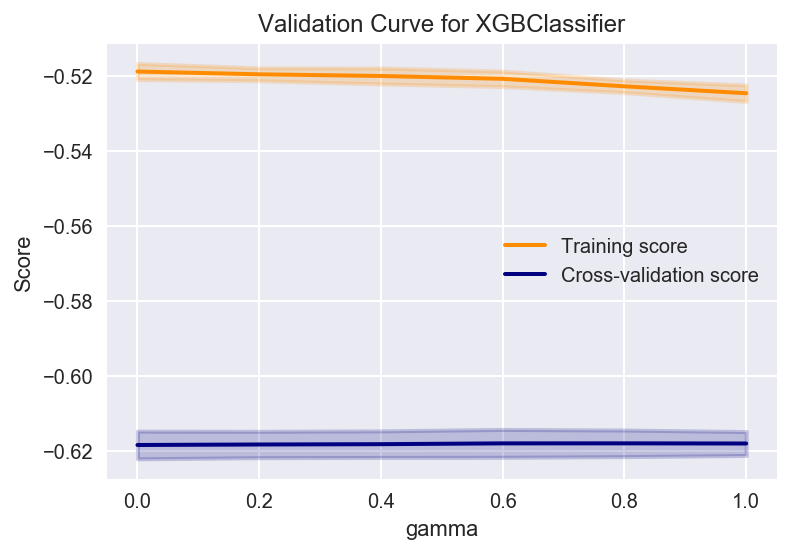

In [148]:
# so %timeit works with multiline arguments
kwargs = dict(
    estimator=xgb_clf, X=X_train, y=y_train,
    param_name='gamma', param_range=np.arange(0, 1.2, .2),
    cv=3, scoring=scoring, n_jobs=-1,
)
%timeit -r1 -n1 plot_validation_curve(**kwargs)

Conclusion:
- Keep `gamma` at default 0
- not significant difference,
- can tune again later

#### Step 3: Tune `subsample`, `colsample_bytree` and `colsample_bylevel`

- subsample [default=1]
    - subsample ratio of the training instance.
    - Setting it to 0.5 means that XGBoost randomly collected half of the data instances to grow trees
    and this will prevent overfitting.
    - range: (0,1]  
- colsample_bytree [default=1]
    - subsample ratio of columns when constructing each tree.
    - range: (0,1]
- colsample_bylevel [default=1]
    - subsample ratio of columns for each split, in each level.
    - range: (0,1]

__First try:__
- Before good learning rate etc.

Runtime: 0min 26s



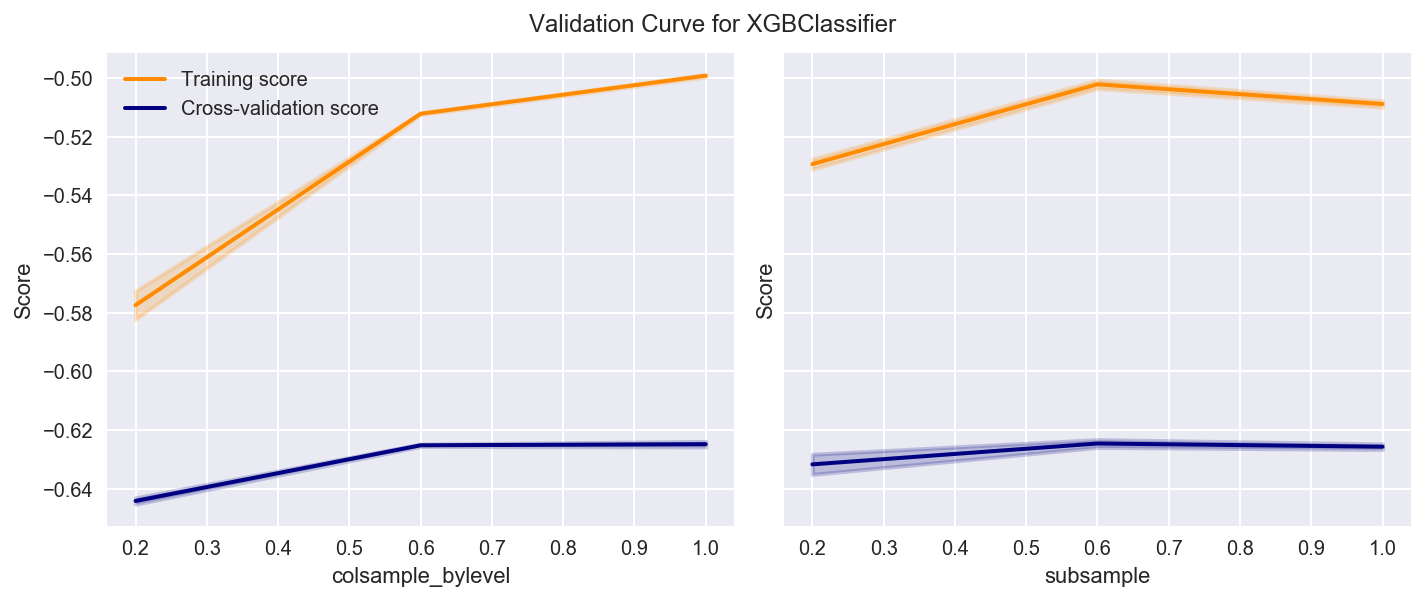

In [273]:
cv = 3

xgb_clf = XGBClassifier(
    objective='multi:softprob',
    learning_rate=0.1, n_estimators=120,
    subsample=0.8, colsample_bytree=0.8,
    missing=-999, nthread=1, seed=SEED,
    max_depth=6, min_child_weight=1,
)

start = time.time()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

param_1 = 'colsample_bylevel'
param_2 = 'subsample'

param_range = np.arange(.2, 1.2, .2)

kwargs = dict(
    estimator=xgb_clf, X=X_train, y=y_train,
    param_name=param_1, param_range=param_range,
    cv=cv, scoring=scoring, n_jobs=-1, ax=ax1, 
)
plot_validation_curve(**kwargs)

kwargs = dict(
    estimator=xgb_clf, X=X_train, y=y_train,
    param_name=param_2, param_range=param_range,
    cv=cv, scoring=scoring, n_jobs=-1, ax=ax2, 
)
plot_validation_curve(**kwargs)

fig.suptitle(ax1.get_title(), y=1.03)

ax1.set_title('')
ax2.set_title('')
ax2.legend('')

end = time.time()
print('Runtime: {}min {}s\n'.format(*to_min_secs(end-start)))

plt.tight_layout()

24.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


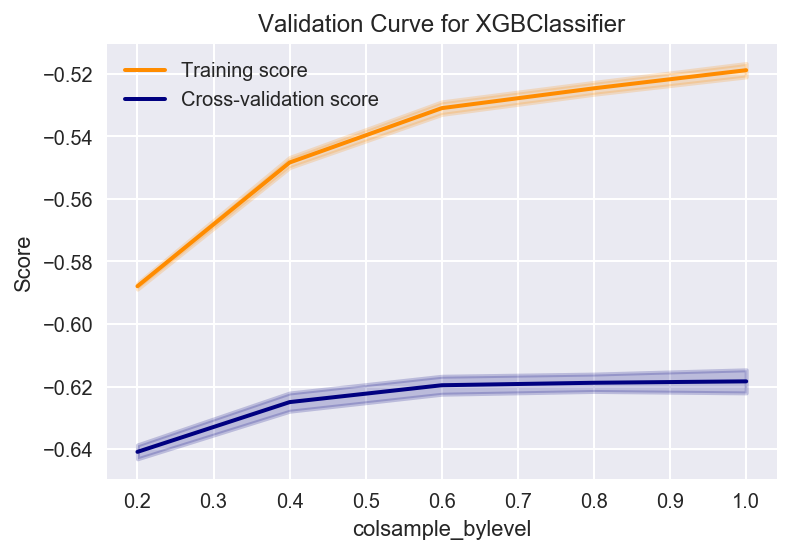

In [159]:
# so %timeit works with multiline arguments


#### Step 5: Tune `reg_alpha` and `reg_lambda`
- lambda [default=1, alias: reg_lambda]
    - L2 regularization term on weights, increase this value will make model more conservative.
- alpha [default=0, alias: reg_alpha]
    - L1 regularization term on weights, increase this value will make model more conservative.

In [161]:
RUN_XGB = True

if RUN_XGB:
    cv = 3

    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        learning_rate=0.1, n_estimators=120,
        subsample=0.8, colsample_bytree=0.8,
        missing=-999, nthread=1, seed=SEED,
        max_depth=6, min_child_weight=1,
    )
    
#     params = dict(
#         reg_alpha=[0, 0.05, 0.1, 0.2, 0.5],
#         reg_lambda=[0, 0.05, 0.1, 0.2, 0.5],
#     )
    
    params = [
        dict(reg_alpha=[0, 0.05, 0.1, 0.2, 0.5]),
        dict(reg_lambda=[0, 0.05, 0.1, 0.2, 0.5]),
    ]
    
    grid = GridSearchCV(xgb_clf, params, n_jobs=-1,
                        scoring=scoring, cv=cv)

    %timeit -r1 -n1 grid.fit(X_train, y_train)

    print(best_grid_score(grid))

1min 26s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid CV score: -0.6179 ± 0.0033 (mean ± std. dev.)
Train score:        -0.5221 ± 0.0020 (mean ± std. dev.)

*** For parameters: ***
reg_alpha=0.5


Output:
```
3min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid CV score: -0.6178 ± 0.0034 (mean ± std. dev.)
Train score:        -0.5163 ± 0.0016 (mean ± std. dev.)

*** For parameters: ***
reg_alpha=0.5
reg_lambda=0.2
```

In [162]:
ge = GridSearchExplorer(grid)
ge.plot('reg_alpha')

TypeError: unorderable types: dict() < dict()

#### Step 6: Tune `reg_alpha` and `reg_lambda`

### Feature Selection

From [StackEx](https://datascience.stackexchange.com/questions/12318/how-do-i-interpret-the-output-of-xgboost-importance): How do i interpret the output of XGBoost importance?

_Gain_: the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model
- A higher value of this metric when compared to another feature implies it is more important for generating a prediction.
- It is the most relevant attribute to interpret the relative importance of each feature.

_Weight_: (or fscore) is the percentage representing the relative number of times a particular feature occurs in the trees of the model. 
- In the above example, if feature1 occurred in 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3; then the weightage for feature1 will be 2+1+3 = 6.
- The frequency for feature1 is calculated as its percentage weight over weights of all features.

_Cover_: the relative number of observations related to this feature. 
- For example, if you have 100 observations, 4 features and 3 trees, and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17 observations. 
- This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features' cover metrics.

In [76]:
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    learning_rate=0.1, n_estimators=120,
    subsample=0.8, colsample_bytree=0.8,
    missing=-999, nthread=1, seed=SEED,
    max_depth=6, min_child_weight=1,
)

fit_params = dict(X=X_train, y=y_train, eval_metric='mlogloss',
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  verbose=False,
)
%timeit -r1 -n1 xgb_clf.fit(**fit_params)

23.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


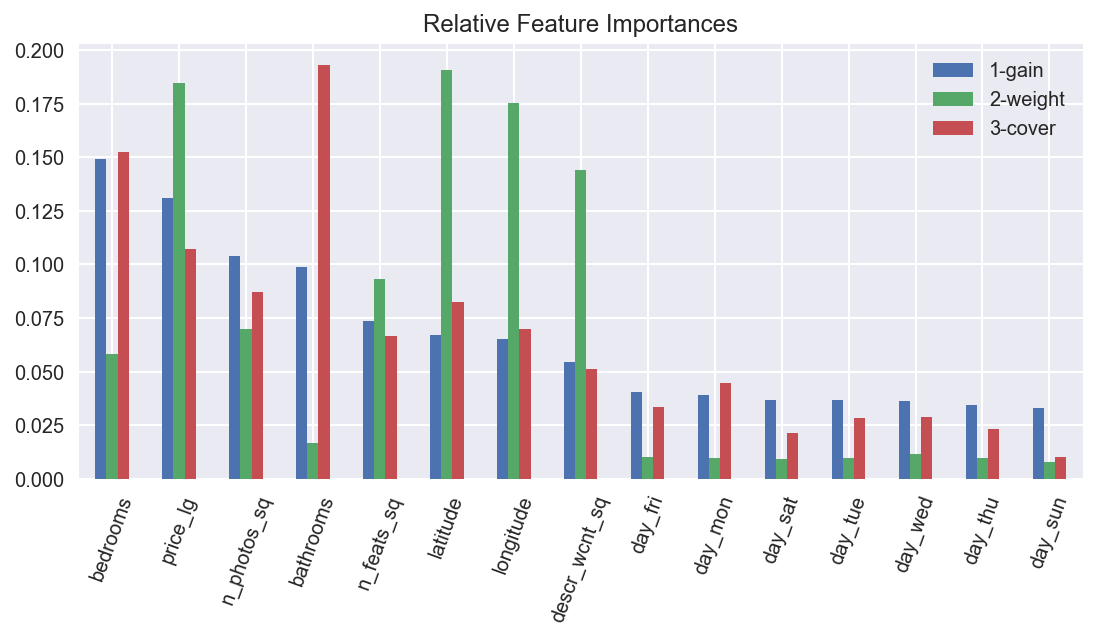

In [193]:
score_dict = {}
for i, imp_type in enumerate(['gain', 'weight', 'cover'], 1):
    
    col_name = str(i)+'-'+imp_type  # For correct hue ordering
    score_dict[col_name] = bst.get_score(importance_type=imp_type)
feat_scores = (pd.DataFrame(score_dict)
                 .apply(lambda x: x/sum(x))
                 .sort_values('1-gain', ascending=False)
)
ax = feat_scores.plot(kind='bar', rot=70, figsize=(9, 4))
ax.set_title('Relative Feature Importances')

plt.show()

In [147]:
x = (pd.DataFrame(bst.get_score(importance_type='gain'), index=['0']).T
   .sort_values(by='0', ascending=False)
   .plot(kind='bar', ax=ax1)
)

In [ ]:
plt.title('Feature Score - Gain')
(pd.DataFrame(bst.get_score(importance_type='gain'), index=['0']).T
   .sort_values(by='0', ascending=False)
   .plot(kind='bar')
)

In [127]:
df.plot()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,manager_id,photos,price,street_address
listing_id,,,,,,,,,,,,,,
7211212,1.5000,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],2,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
7150865,1.0000,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",1,40.7947,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
6887163,1.0000,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",3,40.7388,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
6888711,1.0000,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",1,40.7539,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
6934781,1.0000,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],1,40.8241,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street
6894514,2.0000,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],2,40.7429,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street
6930771,1.0000,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",1,40.8012,-73.9660,01287194f20de51872e81f660def4784,[https://photos.renthop.com/2/6930771_7e3622b6...,3600,210 West 107th Street
6867392,2.0000,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",1,40.7427,-73.9957,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6867392_b18283f6...,5645,155 West 21st Street
6898799,1.0000,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",2,40.8234,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace
